# Experiment 1: Not sure what to call this (False Goal Test?)
The different ToM models may struggle with learning which goals are relevant to which agents. For example, an agent wants to go to point B. The path the agent takes will go by point A, but historically, this agent does not visit point A. How well do models learn goal relevance for agents?  

We can test this by designing specific paths for the agents. We will choose the highest probability goal for each agent and the lowest probability goal. Then, we will for the agent to start from a position before the low probability goal such that this goal has to be passed on the way to the true goal. As the agent approaches the false goal, are the models fooled with high certainty that this is the correct goal driving the agent?  

Steps:
1. Load agents and data from experiment 0
2. Choose the starting and goal nodes for each agent
3. Run an experiment for each agent (100) using the models trained on experiment 0 data.
4. Visualize the performance

In [13]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

In [5]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [8]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

In [36]:
def visualize_map(campus,
                  path=None,
                  max_goal=None,
                  min_goal=None, 
                  start_goal=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if max_goal:
        goal_coords = [campus.node_coords[max_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Max Goal")

    if min_goal:
        goal_coords = [campus.node_coords[min_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="red",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Min Goal")

    if start_goal:
        goal_coords = [campus.node_coords[start_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="lightgreen",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Start Node")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

## Step 1: Loading Data

In [24]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #25
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_25_20250501_144413
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


In [9]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [10]:
import pickle
# if you used dill, just replace pickle with dill

with open('agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [14]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [15]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [16]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Choosing Start and Goal

In [74]:
from tqdm import tqdm

In [76]:
to_remove = []
for agent in tqdm(agents, desc="Processing agents"):
    max_goal_idx = np.argmax(agent.goal_distribution)
    max_goal = goals[max_goal_idx]
    
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]

    G = campus.G_undirected  # your undirected NetworkX graph

    candidates = []
    for s in G.nodes():
        if s in (min_goal, max_goal):
            continue  # optional: don’t start right on one of the goals
        try:
            path = nx.shortest_path(G, s, max_goal, weight="length")
        except nx.NetworkXNoPath:
            continue
        if min_goal in path:
            candidates.append(s)
    
    if not candidates:
        print("No start node forces a pass by min_goal on the way to max_goal")
        to_remove.append(agent)
        continue

    agent.goal_node = max_goal
    agent.start_node = random.choice(candidates)
    agent.current_node = agent.start_node
    agent.plan_path()

    if min_goal not in agent.path:
        print("Problem, missing min goal in path")

Processing agents: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [07:32<00:00,  5.09s/it]


In [64]:
agents = [agent for agent in agents if agent not in to_remove]

In [77]:
# Get each agent's path 
for agent in agents:
    agent.plan_path()

## Step 3: Run the Models

In [79]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [80]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [81]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

In [82]:
for agent in agents:
    posteriors_data[agent.id] = btom.update_agent_posterior_over_path(agent, agent.path)
# Reset the posteriors for new episode
btom.reset_posteriors()

## Step 4: Calculate Brier Score  
We will calculate the brier score for each 10% portion of the path (same as before), but only leading up to the false goal. A model that does not learn historical trends will have a higher brier score since it will be more confident in the false goal. 

In [83]:
def brier_score(true_goal, p_dist):
    """
    Multi-class Brier score given a dict goal→prob.
    """
    score = 0.0
    for g, p in p_dist.items():
        y = 1.0 if g == true_goal else 0.0
        score += (p - y) ** 2
    return float(score)


def brier_along_path(path, true_goal, posteriors_by_step, goals):
    """
    Compute Brier scores at 0%, 10%, …, 100% of the path.
    
    Parameters
    ----------
    path : list
        The sequence of states (or state-action tuples).
    true_goal : hashable
        The ground-truth goal for this trajectory.
    posteriors_by_step : dict[int, dict] or list[dict]
        Either
          * a dict mapping step index 1..n → posterior dict, OR
          * a list of posterior dicts in step-order (len = n).
        Each posterior dict maps each goal → P(goal | trajectory up to that step).
    
    Returns
    -------
    dict[float, float]
        Mapping fraction → Brier score.
    """
    n = len(path) - 1
    if n < 1:
        raise ValueError("Path must have at least 2 states to define transitions")

    # uniform prior for t=0
    uniform = {g: 1.0/len(goals) for g in goals}

    results = []
    for frac in np.linspace(0, 1, 11):  # 0.0,0.1,...,1.0
        t = int(np.floor(frac * n))
        if t == 0:
            p_dist = uniform
        else:
            p_dist = posteriors_by_step[t-1]
        results.append(brier_score(true_goal, p_dist))

    return results

In [88]:
scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    # Select the path proportion 
    path = agent.path
    #false_goal_idx = path.index(min_goal)
    #path = path[:false_goal_idx + 1]
    
    scores.append(brier_along_path(path, 
                              agent.goal_node, 
                              posteriors_data[agent.id], 
                              goals))

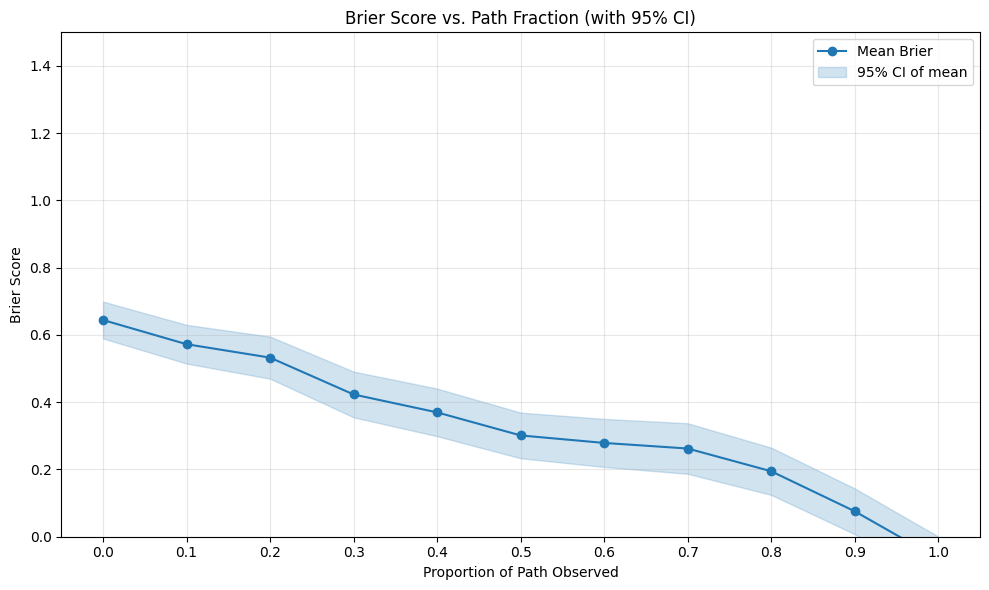

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)   # shape (N, 11)
props = np.linspace(0, 1, arr.shape[1])

# Number of trajectories
N = arr.shape[0]

# Compute mean and SEM at each fraction
mean_scores = arr.mean(axis=0)
sem_scores  = arr.std(axis=0, ddof=1) / np.sqrt(N)

# 95% CI half‐width (approx Normal)
ci95 = 1.96 * sem_scores

lower = mean_scores - ci95
upper = mean_scores + ci95

plt.figure(figsize=(10,6))
plt.plot(props, mean_scores, '-o', label='Mean Brier')
plt.fill_between(props, lower, upper,
                 color='C0', alpha=0.2,
                 label='95% CI of mean')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction (with 95% CI)')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [95]:
def fooled_score(true_goal, p_dist, false_goal):
    """
    Fooled scores counts .
    """
    prob_true_goal = p_dist[true_goal]
    prob_false_goal = p_dist[false_goal]
    return prob_false_goal - prob_true_goal


def fooled_along_path(path, true_goal, false_goal, posteriors_by_step, goals):
    """
    Compute Brier scores at 0%, 10%, …, 100% of the path.
    
    Parameters
    ----------
    path : list
        The sequence of states (or state-action tuples).
    true_goal : hashable
        The ground-truth goal for this trajectory.
    posteriors_by_step : dict[int, dict] or list[dict]
        Either
          * a dict mapping step index 1..n → posterior dict, OR
          * a list of posterior dicts in step-order (len = n).
        Each posterior dict maps each goal → P(goal | trajectory up to that step).
    
    Returns
    -------
    dict[float, float]
        Mapping fraction → Brier score.
    """
    n = len(path) - 1
    if n < 1:
        raise ValueError("Path must have at least 2 states to define transitions")

    # uniform prior for t=0
    uniform = {g: 1.0/len(goals) for g in goals}

    results = []
    for frac in np.linspace(0, 1, 11):  # 0.0,0.1,...,1.0
        t = int(np.floor(frac * n))
        if t == 0:
            p_dist = uniform
        else:
            p_dist = posteriors_by_step[t-1]
        results.append(fooled_score(true_goal, p_dist, false_goal))

    return results

In [100]:
fooled_scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    # Select the path proportion 
    path = agent.path
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    
    fooled_scores.append(fooled_along_path(path, 
                                    agent.goal_node,
                                    min_goal,
                                    posteriors_data[agent.id],
                                    goals))

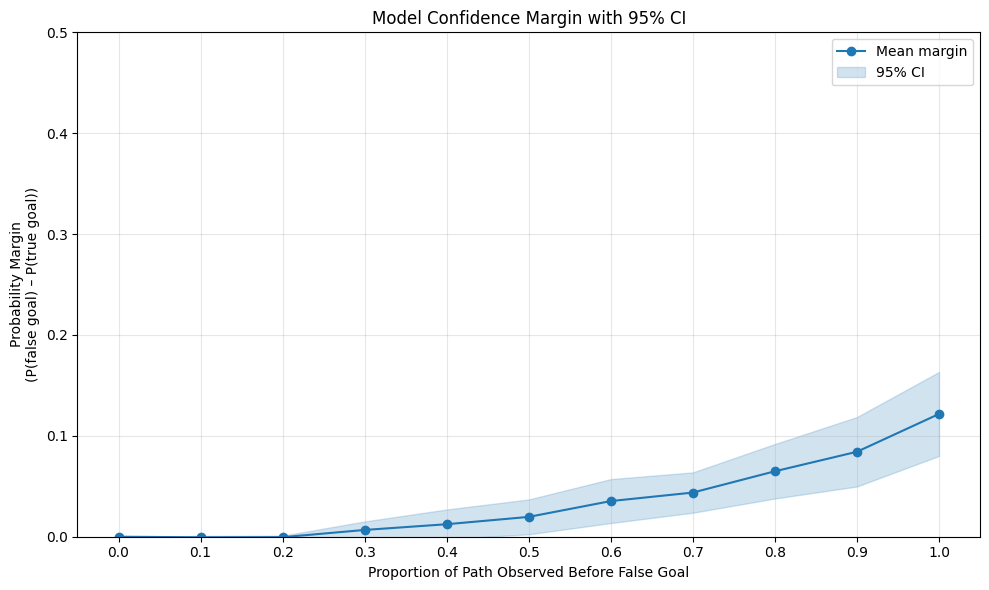

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `fooled_scores` is your (n_trajectories × n_fractions) array:
arr = np.array(fooled_scores)   # shape (N, 11)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean and standard error of the mean (SEM) at each fraction
mean_scores = arr.mean(axis=0)
sem_scores  = arr.std(axis=0, ddof=1) / np.sqrt(arr.shape[0])

# 95% CI half‐width
ci95 = 1.96 * sem_scores

lower = mean_scores - ci95
upper = mean_scores + ci95

plt.figure(figsize=(10,6))
plt.plot(props, mean_scores, '-o', label='Mean margin')
plt.fill_between(props, lower, upper,
                 color='C0', alpha=0.2,
                 label='95% CI')
plt.xlabel('Proportion of Path Observed Before False Goal')
plt.ylabel('Probability Margin\n(P(false goal) – P(true goal))')
plt.title('Model Confidence Margin with 95% CI')
plt.xticks(props)
plt.ylim(0, .5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()